# Text Classification: Language Anxiety

## Importing Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D

from tensorflow.keras.optimizers import AdamW
from sklearn.utils import shuffle

import keras

from sklearn.utils import class_weight
from sklearn.metrics import f1_score

## Reading The Dataset

In [ ]:
df = pd.read_excel('dataset_2class.xlsx')
df = df[['post','LA Classification']]
df.head()

,post,LA Classification
0,The place I've been to that I love and always ...,Anxiety
1,"My favorite place is Hat Yai in Thailand, spec...",No Anxiety
2,One of my favorite places that i have been vis...,No Anxiety
3,"When I was in 6th grade, I went on a vacation ...",Anxiety
4,"My favorite place is Bali, I like Bali so much...",Anxiety


## Checking Class Distribution

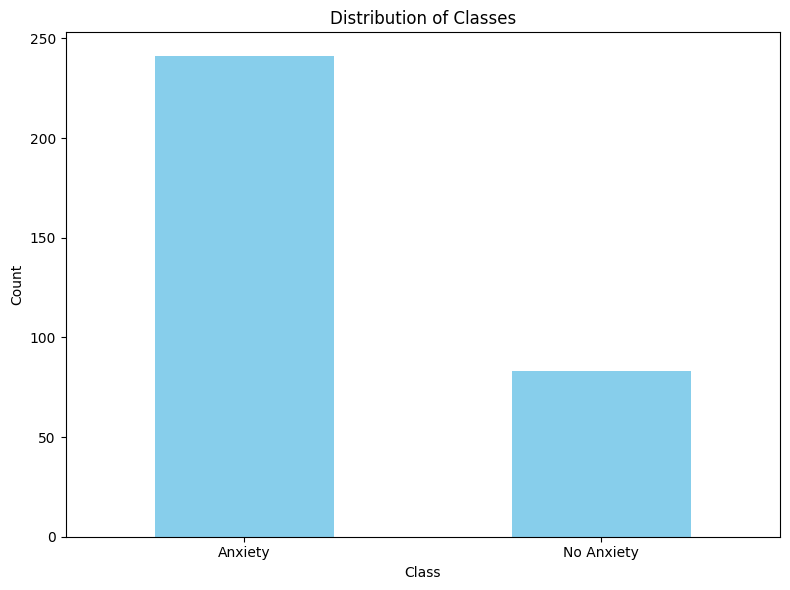

In [ ]:
# Mengambil nilai perhitungan distribusi kelas
class_counts = df['LA Classification'].value_counts()

# Membuat diagram batang
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Untuk memutar label sumbu x agar lebih mudah dibaca
plt.tight_layout()
plt.show()

In [ ]:
df['LA Classification'].value_counts()

LA Classification
Anxiety       241
No Anxiety     83
Name: count, dtype: int64

## Encode Target Variable

In [ ]:
# Menggunakan mapping manual dengan map
df['la_class'] = df['LA Classification'].map({'Anxiety': 1, 'No Anxiety': 0})

# Menampilkan hasil
print("Mapping kelas ke nilai encoded:")
print(df[['LA Classification', 'la_class']])

# Menghapus kolom asli
df.drop(columns=['LA Classification'], inplace=True)

Mapping kelas ke nilai encoded:
Anxiety: 0
No Anxiety: 1


## Contraction Mapping

In [ ]:
contraction_mapping = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text, contraction_mapping):
    for contraction, expanded in contraction_mapping.items():
        text = text.replace(contraction, expanded)
    return text

df['post'] = df['post'].apply(lambda x: expand_contractions(x, contraction_mapping))

## Cleaning The Text

In [ ]:
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Hapus karakter non-alphanumeric
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Konversi teks ke huruf kecil
    text = text.lower()
    # Split teks menjadi kata-kata
    words = text.split()
    # Lematisasi dan hapus stop words
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    # Gabungkan kata-kata kembali menjadi satu string
    processed_text = ' '.join(words)

    return processed_text

df['post'] = df['post'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Calculating Text Length

In [ ]:
df['text_length'] = df['post'].apply(len)
df.head()

,post,la_class,text_length
0,place love always feel comfortable going malay...,0,351
1,favorite place hat yai thailand specifically a...,1,538
2,one favorite place visited disneyland elementa...,1,673
3,th grade went vacation family one place think ...,0,463
4,favorite place bali like bali much people nice...,0,441


## Splitting The Dataset Into Train And Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['post'], df['la_class'], test_size = 0.2, stratify = df['la_class'], random_state = 42)

## Hyperparameter

In [ ]:
max_len = df['text_length'].max()
trunc_type = 'post'
padding_type = 'pre'
oov_tok = '<OOV>'
vocab_size = 500

## Tokenizing

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

## Get The Word Index

In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4290

## Creating Train Sequences

In [ ]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

## Creating Test Sequences

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (259, 1882)
Shape of testing tensor:  (65, 1882)


## Dense Architecture

In [ ]:
# Menghitung class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

# Definisikan nilai class weights sebagai dictionary
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.6709844559585493, 1: 1.9621212121212122}

### Define Paramter

In [ ]:
vocab_size = 500
embedding_dim = 16
drop_value = 0.2

## GRU Architecture

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(32, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'tanh'))

In [ ]:
optimizer = tf.keras.optimizers.AdamW()

model3.compile(loss = 'binary_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])

In [ ]:
num_epochs = 15
# early_stop = EarlyStopping(monitor='val_loss', patience=7)
history = model3.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     class_weight=class_weight_dict,
                    #  callbacks =[early_stop],
                     verbose=2)

Epoch 1/15
9/9 - 5s - loss: 2.7956 - accuracy: 0.7452 - val_loss: 0.7057 - val_accuracy: 0.7385 - 5s/epoch - 509ms/step
Epoch 2/15
9/9 - 1s - loss: 1.1711 - accuracy: 0.7452 - val_loss: 0.6289 - val_accuracy: 0.7385 - 1s/epoch - 149ms/step
Epoch 3/15
9/9 - 1s - loss: 1.0196 - accuracy: 0.7452 - val_loss: 0.5952 - val_accuracy: 0.7385 - 1s/epoch - 145ms/step
Epoch 4/15
9/9 - 1s - loss: 0.9361 - accuracy: 0.7452 - val_loss: 0.5754 - val_accuracy: 0.7385 - 861ms/epoch - 96ms/step
Epoch 5/15
9/9 - 1s - loss: 0.8547 - accuracy: 0.7452 - val_loss: 0.5660 - val_accuracy: 0.7385 - 818ms/epoch - 91ms/step
Epoch 6/15
9/9 - 1s - loss: 0.7890 - accuracy: 0.7452 - val_loss: 0.5702 - val_accuracy: 0.7385 - 650ms/epoch - 72ms/step
Epoch 7/15
9/9 - 1s - loss: 0.7135 - accuracy: 0.7413 - val_loss: 0.6016 - val_accuracy: 0.7385 - 638ms/epoch - 71ms/step
Epoch 8/15
9/9 - 1s - loss: 0.6584 - accuracy: 0.7490 - val_loss: 0.6606 - val_accuracy: 0.6769 - 787ms/epoch - 87ms/step
Epoch 9/15
9/9 - 1s - loss: 0.

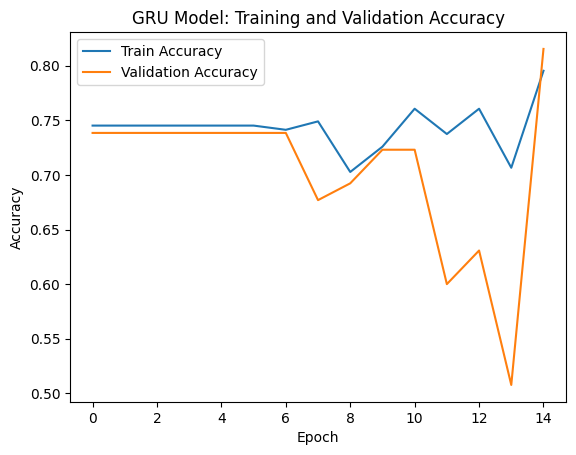

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model: Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

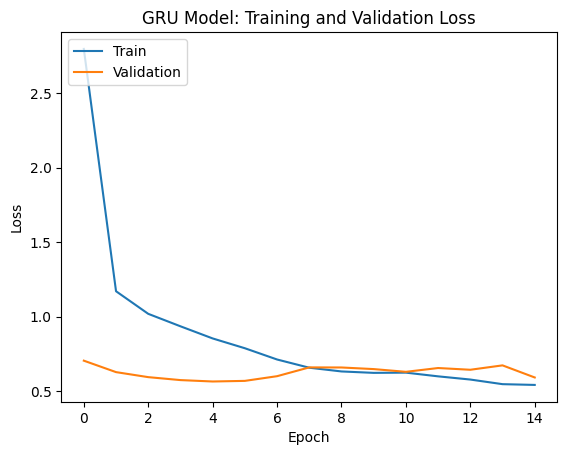

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('GRU Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Prediksi probabilitas
y_pred_prob = model3.predict(testing_padded)

# Mengubah probabilitas menjadi kelas biner
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Tampilkan classification report
print(classification_report(y_test, y_pred_binary))

3/3 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        48
           1       0.65      0.65      0.65        17

    accuracy                           0.82        65
   macro avg       0.76      0.76      0.76        65
weighted avg       0.82      0.82      0.82        65



## Saving The Model

In [ ]:
# import pickle

# # Simpan model dan history
# model3.save('model3.h5')
# with open('history.pkl', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load The Model

In [ ]:
# import tensorflow as tf

# # Muat model dari file .h5
# model_path = "model3.h5"
# loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
# import numpy as np
# from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# # Misalkan testing_padded dan y_test sudah tersedia
# # Prediksi probabilitas
# y_pred_prob = loaded_model.predict(testing_padded)

# # Mengubah probabilitas menjadi kelas biner
# y_pred_binary = (y_pred_prob > 0.5).astype(int)

# # Hitung dan tampilkan akurasi
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"Accuracy: {accuracy}")

# # Hitung dan tampilkan skor ROC-AUC
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# print(f"ROC-AUC Score: {roc_auc}")

# # Tampilkan classification report
# print(classification_report(y_test, y_pred_binary))